In [1]:
# Importing the required libraries
import pandas_datareader as pdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error

%matplotlib inline

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Data Collection

- df = pdr.get_data_tiingo('AAPL', api_key = 'key')

- df.to_csv("AAPL.csv")

In [2]:
df = pd.read_csv('AAPL.csv')

In [3]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-06-29 00:00:00+00:00,94.40,94.550,93.63,93.97,36531006,22.043669,22.078696,21.863864,21.943259,146124024,0.0,1.0
1,AAPL,2016-06-30 00:00:00+00:00,95.60,95.770,94.30,94.44,35836356,22.323886,22.363583,22.020318,22.053010,143345424,0.0,1.0
2,AAPL,2016-07-01 00:00:00+00:00,95.89,96.465,95.33,95.49,26026540,22.391605,22.525875,22.260837,22.298199,104106160,0.0,1.0
3,AAPL,2016-07-05 00:00:00+00:00,94.99,95.400,94.46,95.39,27705210,22.181442,22.277183,22.057680,22.274848,110820840,0.0,1.0
4,AAPL,2016-07-06 00:00:00+00:00,95.53,95.660,94.37,94.60,30949090,22.307540,22.337896,22.036664,22.090372,123796360,0.0,1.0


In [4]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,AAPL,2021-06-21 00:00:00+00:00,132.30,132.41,129.21,130.30,79663316,132.30,132.41,129.21,130.30,79663316,0.0,1.0
1253,AAPL,2021-06-22 00:00:00+00:00,133.98,134.08,131.62,132.13,74783618,133.98,134.08,131.62,132.13,74783618,0.0,1.0
1254,AAPL,2021-06-23 00:00:00+00:00,133.70,134.32,133.23,133.77,60214200,133.70,134.32,133.23,133.77,60214200,0.0,1.0
1255,AAPL,2021-06-24 00:00:00+00:00,133.41,134.64,132.93,134.45,68710998,133.41,134.64,132.93,134.45,68710998,0.0,1.0
1256,AAPL,2021-06-25 00:00:00+00:00,133.11,133.89,132.81,133.46,70783746,133.11,133.89,132.81,133.46,70783746,0.0,1.0


## Data Preprocessing

In [5]:
df1 = df.reset_index()['close']

In [6]:
df1.shape

(1257,)

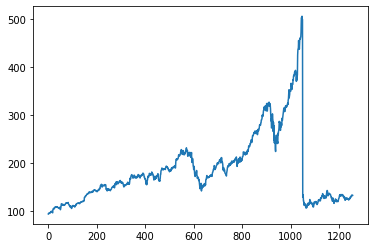

In [7]:
plt.plot(df1)

__LSTM are sensetive to the scale so we will apply MinMaxScaler__

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [9]:
df1.shape

(1257, 1)

## Train Test splitting

In [10]:
training_size = int(len(df1)*0.70)
test_size = len(df1) - training_size

train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [11]:
# Converting the array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    data_X, data_Y = [], []
    for i in range(len(dataset)-time_step-1):
        record = dataset[i:(i+time_step), 0]
        #i=0, 0,1,2,3-----99
        data_X.append(record)
        data_Y.append(dataset[i + time_step, 0])
    return np.array(data_X), np.array(data_Y)

In [12]:
# Reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [13]:
print(X_train)

[[0.         0.00291481 0.00361923 ... 0.03087274 0.0378683  0.03777114]
 [0.00291481 0.00361923 0.00143312 ... 0.0378683  0.03777114 0.03803833]
 [0.00361923 0.00143312 0.00274478 ... 0.03777114 0.03803833 0.04209478]
 ...
 [0.27783041 0.288178   0.27698025 ... 0.45048459 0.45182054 0.45019311]
 [0.288178   0.27698025 0.26626831 ... 0.45182054 0.45019311 0.45087323]
 [0.27698025 0.26626831 0.24032646 ... 0.45019311 0.45087323 0.4494644 ]]


In [14]:
# Reshaping the input in (samples, time_steps, features) format which is requried for the LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

In [15]:
print(X_train.shape)

(778, 100, 1)


## Model Building

In [16]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100, batch_size=64)

Epoch 1/100
13/13 [==============================] - 5s 384ms/step - loss: 5.6636e-05 - val_loss: 0.0035
Epoch 2/100
13/13 [==============================] - 5s 375ms/step - loss: 5.0211e-05 - val_loss: 0.0035
Epoch 3/100
13/13 [==============================] - 5s 370ms/step - loss: 4.7023e-05 - val_loss: 0.0035
Epoch 4/100
13/13 [==============================] - 5s 370ms/step - loss: 4.7556e-05 - val_loss: 0.0035
Epoch 5/100
13/13 [==============================] - 5s 367ms/step - loss: 4.7818e-05 - val_loss: 0.0035
Epoch 6/100
13/13 [==============================] - 5s 361ms/step - loss: 4.6954e-05 - val_loss: 0.0035
Epoch 7/100
13/13 [==============================] - 5s 384ms/step - loss: 4.6878e-05 - val_loss: 0.0035
Epoch 8/100
13/13 [==============================] - 5s 409ms/step - loss: 4.7814e-05 - val_loss: 0.0035
Epoch 9/100
13/13 [==============================] - 5s 372ms/step - loss: 4.6992e-05 - val_loss: 0.0035
Epoch 10/100
13/13 [==============================] - 5

13/13 [==============================] - 5s 375ms/step - loss: 4.8136e-05 - val_loss: 0.0034
Epoch 79/100
13/13 [==============================] - 5s 416ms/step - loss: 4.7631e-05 - val_loss: 0.0034
Epoch 80/100
13/13 [==============================] - 5s 382ms/step - loss: 4.6577e-05 - val_loss: 0.0034
Epoch 81/100
13/13 [==============================] - 5s 400ms/step - loss: 4.8496e-05 - val_loss: 0.0034
Epoch 82/100
13/13 [==============================] - 5s 404ms/step - loss: 4.7585e-05 - val_loss: 0.0034
Epoch 83/100
13/13 [==============================] - 5s 393ms/step - loss: 4.6860e-05 - val_loss: 0.0034
Epoch 84/100
13/13 [==============================] - 5s 418ms/step - loss: 5.3022e-05 - val_loss: 0.0034
Epoch 85/100
13/13 [==============================] - 6s 449ms/step - loss: 4.8275e-05 - val_loss: 0.0034
Epoch 86/100
13/13 [==============================] - 5s 385ms/step - loss: 5.0681e-05 - val_loss: 0.0034
Epoch 87/100
13/13 [==============================] - 5s 36

##  Prediction and Performance Metrics

In [28]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [29]:
##Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [30]:
### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train,train_predict))

183.54756346709235

In [31]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

227.40228146543902

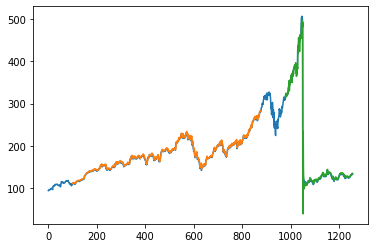

In [26]:
import numpy
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()